In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
%matplotlib inline
# 设为白色网格背景
sns.set(font='SimHei', style='ticks', context='notebook', palette='deep')

In [4]:
df = pd.read_csv('d://datasets//train_nitration_941_standard.csv')
# df = pd.read_csv('datasets/train_nitration_941_standard.csv')
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].map(lambda x: x if x==1 else 0) # 调整正负样本 label 标注
print(df.shape)

(212, 942)


In [5]:
f_name = df.columns[1:].values
t_name = df.iloc[:, 0].unique()

In [6]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score

In [44]:
# 引用相关分类器
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

In [46]:
# 构建基分类器组
estimators = [
    ('rf', RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=42)),
    ('svm', SVC(kernel='sigmoid', random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=20, n_jobs=-1, random_state=42)),
    ('lgb', lgb.LGBMClassifier(boosting_type='goss', n_estimators=20, n_jobs=-1, random_state=42))
    ]

In [47]:
# 构建元分类器
clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=5)

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

In [16]:
%%time
# ANOVA 选取 TOP 100
model_f1 = SelectKBest(f_classif, k=100).fit(X, y)

Wall time: 9.99 ms
D:\Dev\miniconda3\envs\dl\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: UserWarning: Features [459 522 659 759] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
D:\Dev\miniconda3\envs\dl\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [17]:
# 降序排列特征权重
f1_idxs = np.argsort(-model_f1.scores_)

In [18]:
# 获取 TOP 20 特征名称
print(model_f1.scores_[f1_idxs[0:20]])
print(f_name[f1_idxs[0:20]])

[13.23522951 12.97752809 12.97752809 12.26996083 12.26865338 11.58243038
 11.57351217 10.22684885 10.05224132  9.6737693   9.41785955  9.35848525
  8.58075435  8.38380934  8.29954749  8.08341137  7.85415317  7.55395683
  7.35615844  7.20601723]
['Site2_PSSM_L' 'Site15_AA_12' 'Site6_AA_15' 'Site7_PSSM_P' 'Site6_PSSM_R'
 'Site20_PSSM_N' 'Site2_PSSM_I' 'Site14_AA_Factor_1' 'Site6_AA_Factor_5'
 'Site20_PSSM_K' 'Site6_PSSM_Q' 'Site15_PSSM_Q' 'Site13_AA_15'
 'Site19_AA_Factor_1' 'Site20_PSSM_V' 'Site10_PSSM_V' 'Site15_PSSM_F'
 'Site6_AA_10' 'Site19_AA_Factor_5' 'Site6_PSSM_K']


In [48]:
%time y_pred_list = [cross_val_predict(clf, X[:, f1_idxs[0:i+1]], y, cv=10, n_jobs=-1) for i in range(10, 400)]

Wall time: 14min 16s


In [49]:
%%time
mcc_estimators = [matthews_corrcoef(y, y_pred_list[i]) for i in range(0, len(y_pred_list))]
acc_estimators = [accuracy_score(y, y_pred_list[i]) for i in range(0, len(y_pred_list))]

Wall time: 414 ms


In [50]:
print('Max MCC={0}\tMax ACC={1}'.format(np.max(mcc_estimators), np.max(acc_estimators)))

Max MCC=0.7532016523996611	Max ACC=0.910377358490566


In [51]:
print('Max MCC Index={0}\tMax ACC Index={1}'.format(np.argmax(mcc_estimators)+10, np.argmax(acc_estimators)+10))

Max MCC Index=269	Max ACC Index=269


In [52]:
len(y_pred_list)

390

In [55]:
# 画出曲线
x_e = np.linspace(10, 399, 390)

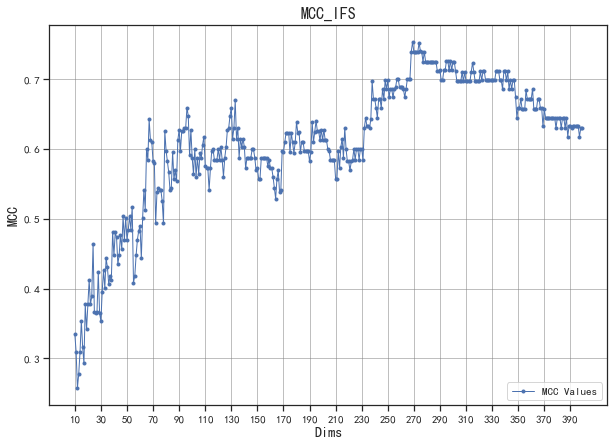

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(x_e, mcc_estimators, label='MCC Values', lw=1.0, color='b', marker='.')
ax.set_title('MCC_IFS',fontsize=16)
ax.set_xlabel('Dims', fontsize=14)
ax.set_xticks(np.arange(10, 400, step=20))
ax.set_ylabel('MCC', fontsize=14)
ax.grid(color='gray', linewidth=0.5)
ax.legend(loc='lower right')